<a href="https://colab.research.google.com/github/fishee82oo/nfs-oil-price-prediction/blob/main/GDELT_data_engineering_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pull GDELT Data

In [ ]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io
from datetime import datetime, timedelta
import time
from typing import List, Dict, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
import logging

from google.cloud import storage
import pickle
import json
import gzip
import os

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("GDELT GKG 2.0 Data Extraction for Oil Price Prediction")
print("=" * 60)
print(f"Target Period: 3 years of data (August 25, 2022 to August 25, 2025)")
print(f"Focus: Daily aggregation aligned to NYMEX WTI close (5:00 PM NYC)")
print("=" * 60)

GDELT GKG 2.0 Data Extraction for Oil Price Prediction
Target Period: 3 years of data (August 25, 2022 to August 25, 2025)
Focus: Daily aggregation aligned to NYMEX WTI close (5:00 PM NYC)


In [ ]:
from google.colab import auth
from google.cloud import storage

print("Authenticating with Google Cloud...")
auth.authenticate_user()

PROJECT_ID = "manifest-vault-470110-k5"
print(f"Using project: {PROJECT_ID}")

GCS_BUCKET_NAME = "gdelt_raw_3_years"
GCS_CHECKPOINT_PATH = "checkpoints/"
GCS_DATA_PATH = "gdelt_data/"

Authenticating with Google Cloud...
Using project: manifest-vault-470110-k5


In [ ]:
def setup_gcs_client():
    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)
    return client, bucket

def save_checkpoint_gcs(data: List[Dict], processed_urls: List[str], failed_urls: List[str],
                      checkpoint_name: str = "gdelt_checkpoint.pkl"):
    client, bucket = setup_gcs_client()

    checkpoint_data = {
        'processed_records': data,
        'processed_urls': processed_urls,
        'failed_urls': failed_urls,
        'timestamp': datetime.now().isoformat(),
        'record_count': len(data),
        'url_count': len(processed_urls)
    }

    blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}{checkpoint_name}")
    blob.upload_from_string(pickle.dumps(checkpoint_data))

    print(f"Checkpoint saved to GCS: {len(data)} records, {len(processed_urls)} URLs processed")

def load_checkpoint_gcs(checkpoint_name: str = "gdelt_checkpoint.pkl") -> Tuple[List[Dict], List[str], List[str]]:
    try:
        client, bucket = setup_gcs_client()
        blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}{checkpoint_name}")

        if blob.exists():
            checkpoint_data = pickle.loads(blob.download_as_bytes())

            records = checkpoint_data.get('processed_records', [])
            processed_urls = checkpoint_data.get('processed_urls', [])
            failed_urls = checkpoint_data.get('failed_urls', [])
            timestamp = checkpoint_data.get('timestamp', 'unknown')

            print(f"Checkpoint loaded from GCS (saved: {timestamp})")
            print(f"Resuming with {len(records)} records, {len(processed_urls)} URLs processed")

            return records, processed_urls, failed_urls
        else:
            print("No checkpoint found in GCS, starting fresh...")
            return [], [], []

    except Exception as e:
        print(f"Error loading checkpoint from GCS: {e}")
        return [], [], []

def save_batch_to_gcs(data_batch: List[Dict], batch_number: int):
    client, bucket = setup_gcs_client()

    json_data = json.dumps(data_batch, ensure_ascii=False, default=str)
    compressed_data = gzip.compress(json_data.encode('utf-8'))

    blob_name = f"{GCS_DATA_PATH}batch_{batch_number:06d}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json.gz"
    blob = bucket.blob(blob_name)
    blob.upload_from_string(compressed_data, content_type='application/gzip')

    print(f"Saved batch {batch_number} ({len(data_batch)} records) to GCS: {blob_name}")

def get_gcs_progress_summary():
    client, bucket = setup_gcs_client()

    data_blobs = list(bucket.list_blobs(prefix=GCS_DATA_PATH))
    total_batches = len(data_blobs)

    checkpoint_blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}gdelt_checkpoint.pkl")
    checkpoint_exists = checkpoint_blob.exists()

    print(f"GCS Progress Summary:")
    print(f"- Data batches stored: {total_batches}")
    print(f"- Checkpoint exists: {checkpoint_exists}")

    if checkpoint_exists:
        checkpoint_data = pickle.loads(checkpoint_blob.download_as_bytes())
        print(f"- Last checkpoint: {checkpoint_data.get('timestamp', 'unknown')}")
        print(f"- Records processed: {checkpoint_data.get('record_count', 0)}")
        print(f"- URLs processed: {checkpoint_data.get('url_count', 0)}")

    return total_batches, checkpoint_exists

In [ ]:
def generate_gdelt_urls(start_date: str, end_date: str) -> List[str]:
    print("Fetching GDELT 2.0 master file list...")

    try:
        response = requests.get("http://data.gdeltproject.org/gdeltv2/masterfilelist.txt", timeout=30)
        if response.status_code != 200:
            raise Exception(f"Failed to fetch master file list: HTTP {response.status_code}")

        lines = response.text.strip().split('\n')

        gkg_urls = []
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.strptime(end_date, '%Y-%m-%d')

        for line in lines:
            if not line.strip():
                continue

            parts = line.strip().split(' ')
            if len(parts) >= 3:
                file_size, hash_val, url = parts[0], parts[1], parts[2]

                if '.gkg.csv.zip' in url:
                    filename = url.split('/')[-1]
                    if len(filename) >= 14:
                        date_str = filename[:8]
                        try:
                            file_date = datetime.strptime(date_str, '%Y%m%d')
                            if start_dt <= file_date <= end_dt:
                                gkg_urls.append(url)
                        except:
                            continue

        print(f"Found {len(gkg_urls)} GKG files in date range")
        return gkg_urls

    except Exception as e:
        print(f"Error fetching master file list: {e}")
        return []

def fetch_gdelt_file(url: str, max_retries: int = 3) -> Optional[pd.DataFrame]:
    columns = [
        'GKGRECORDID', 'V21DATE', 'V2SOURCECOLLECTIONIDENTIFIER', 'V2SOURCECOMMONNAME',
        'V2DOCUMENTIDENTIFIER', 'V1COUNTS', 'V21COUNTS', 'V1THEMES', 'V21THEMES',
        'V1LOCATIONS', 'V21LOCATIONS', 'V1PERSONS', 'V21PERSONS', 'V1ORGANIZATIONS',
        'V21ORGANIZATIONS', 'V1TONE', 'V21TONE', 'V1DATES', 'V21DATES', 'V1GCAM',
        'V21SHARINGIMAGE', 'V21RELATEDIMAGES', 'V21SOCIALIMAGEEMBEDS', 'V21SOCIALVIDEOEMBEDS',
        'V21QUOTATIONS', 'V21ALLNAMES', 'V21AMOUNTS', 'V21TRANSLATIONINFO', 'V21EXTRAS'
    ]

    for attempt in range(max_retries):
        try:
            response = requests.get(url, timeout=30)
            if response.status_code == 200:
                with zipfile.ZipFile(io.BytesIO(response.content)) as z:
                    csv_filename = z.namelist()[0]
                    with z.open(csv_filename) as csvfile:
                        try:
                            df = pd.read_csv(csvfile, sep='\t', names=columns,
                                          dtype=str, low_memory=False, encoding='utf-8')
                            return df
                        except UnicodeDecodeError:
                            csvfile.seek(0)
                            df = pd.read_csv(csvfile, sep='\t', names=columns,
                                          dtype=str, low_memory=False, encoding='latin-1')
                            return df
            elif response.status_code == 404:
                return None
            else:
                logger.warning(f"HTTP {response.status_code} for {url}")

        except UnicodeDecodeError as e:
            logger.warning(f"Encoding error for {url}: {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
        except Exception as e:
            logger.warning(f"Attempt {attempt + 1} failed for {url}: {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)

    return None

def extract_countries_from_locations(locations_str: str) -> List[str]:
    if pd.isna(locations_str) or not locations_str:
        return []

    countries = []
    try:
        location_entries = locations_str.split(';')
        for entry in location_entries:
            if '#' in entry:
                parts = entry.split('#')
                if len(parts) >= 3:
                    country_code = parts[2]
                    if country_code and len(country_code) == 2:
                        countries.append(country_code.upper())
    except:
        pass

    return list(set(countries))

def extract_tone_metrics(tone_str: str) -> Dict[str, float]:
    tone_dict = {
        'tone': 0.0,
        'positive_score': 0.0,
        'negative_score': 0.0,
        'polarity': 0.0,
        'word_count': 0
    }

    if pd.isna(tone_str) or not tone_str:
        return tone_dict

    try:
        parts = tone_str.split(',')
        if len(parts) >= 7:
            tone_dict['tone'] = float(parts[0]) if parts[0] else 0.0
            tone_dict['positive_score'] = float(parts[1]) if parts[1] else 0.0
            tone_dict['negative_score'] = float(parts[2]) if parts[2] else 0.0
            tone_dict['polarity'] = float(parts[3]) if parts[3] else 0.0
            tone_dict['word_count'] = int(float(parts[6])) if parts[6] else 0
    except:
        pass

    return tone_dict

In [ ]:
def continue_extraction_ultra_safe():
    print("Starting ultra-safe extraction (no memory accumulation)...")

    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    try:
        checkpoint_blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}gdelt_checkpoint.pkl")
        if checkpoint_blob.exists():
            checkpoint_data = pickle.loads(checkpoint_blob.download_as_bytes())
            processed_urls = checkpoint_data.get('processed_urls', [])
            failed_urls = checkpoint_data.get('failed_urls', [])
            total_records_so_far = checkpoint_data.get('record_count', 0)
            print(f"Resuming from checkpoint: {len(processed_urls)} URLs done, {total_records_so_far:,} records")
        else:
            processed_urls = []
            failed_urls = []
            total_records_so_far = 0
            print("No checkpoint found, starting fresh")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        processed_urls = []
        failed_urls = []
        total_records_so_far = 0

    all_urls = generate_gdelt_urls('2022-08-25', '2025-08-25')
    all_urls = all_urls[::7 * 4]

    remaining_urls = [url for url in all_urls if url not in processed_urls]
    print(f"Remaining URLs to process: {len(remaining_urls)}")

    if len(remaining_urls) == 0:
        print("All URLs already processed!")
        return

    data_blobs = list(bucket.list_blobs(prefix=GCS_DATA_PATH))
    batch_number = len([blob for blob in data_blobs if blob.name.endswith('.json.gz')]) + 1

    current_batch = []
    records_this_session = 0

    for i, url in enumerate(tqdm(remaining_urls, desc="Fetching GDELT files")):
        try:
            df = fetch_gdelt_file(url)

            if df is not None and len(df) > 0:
                for _, row in df.iterrows():
                    countries = extract_countries_from_locations(row.get('V21LOCATIONS', ''))

                    if not countries:
                        continue

                    tone_metrics = extract_tone_metrics(row.get('V21TONE', ''))

                    for country in countries:
                        record = {
                            'date': row.get('V21DATE', ''),
                            'country': country,
                            'source': row.get('V2SOURCECOMMONNAME', ''),
                            'url': row.get('V2DOCUMENTIDENTIFIER', ''),
                            'themes': row.get('V21THEMES', ''),
                            'tone': tone_metrics['tone'],
                            'positive_score': tone_metrics['positive_score'],
                            'negative_score': tone_metrics['negative_score'],
                            'polarity': tone_metrics['polarity'],
                            'word_count': tone_metrics['word_count'],
                            'persons': row.get('V21PERSONS', ''),
                            'organizations': row.get('V21ORGANIZATIONS', ''),
                        }
                        current_batch.append(record)
                        records_this_session += 1

            processed_urls.append(url)

            if len(current_batch) >= 3000:
                save_batch_to_gcs(current_batch, batch_number)
                current_batch = []
                batch_number += 1
                print(f"Saved batch {batch_number-1}, session total: {records_this_session}")

        except Exception as e:
            logger.error(f"Error processing {url}: {str(e)}")
            failed_urls.append(url)
            processed_urls.append(url)
            continue

        if (i + 1) % 3 == 0:
            minimal_checkpoint = {
                'processed_urls': processed_urls,
                'failed_urls': failed_urls,
                'timestamp': datetime.now().isoformat(),
                'record_count': total_records_so_far + records_this_session,
                'url_count': len(processed_urls)
            }

            checkpoint_blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}gdelt_checkpoint.pkl")
            checkpoint_blob.upload_from_string(pickle.dumps(minimal_checkpoint))

            if (i + 1) % 15 == 0:
                print(f"Checkpoint saved: {len(processed_urls)} URLs, session records: {records_this_session}")

        if i % 10 == 0:
            time.sleep(1)

    if current_batch:
        save_batch_to_gcs(current_batch, batch_number)

    final_checkpoint = {
        'processed_urls': processed_urls,
        'failed_urls': failed_urls,
        'timestamp': datetime.now().isoformat(),
        'record_count': total_records_so_far + records_this_session,
        'url_count': len(processed_urls)
    }

    checkpoint_blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}gdelt_checkpoint.pkl")
    checkpoint_blob.upload_from_string(pickle.dumps(final_checkpoint))

    print(f"Session complete! Added {records_this_session} new records")
    print(f"Total progress: {len(processed_urls)}/{len(all_urls)} URLs ({len(processed_urls)/len(all_urls)*100:.1f}%)")

In [ ]:
continue_extraction_ultra_safe()

In [ ]:
def comprehensive_data_audit():
    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    print("COMPREHENSIVE DATA AUDIT")
    print("=" * 60)

    print("1. CALCULATING TARGET DATA SCOPE")
    print("-" * 40)

    all_target_urls = generate_gdelt_urls('2022-08-25', '2025-08-25')
    sampled_target_urls = all_target_urls[::7 * 4]

    print(f"Target period: 2022-08-25 to 2025-08-25")
    print(f"Total possible URLs: {len(all_target_urls)}")
    print(f"With weekly sampling: {len(sampled_target_urls)}")

    print("\n2. CHECKING CHECKPOINT DATA")
    print("-" * 40)

    try:
        checkpoint_blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}gdelt_checkpoint.pkl")
        if checkpoint_blob.exists():
            checkpoint_data = pickle.loads(checkpoint_blob.download_as_bytes())
            processed_urls = checkpoint_data.get('processed_urls', [])
            failed_urls = checkpoint_data.get('failed_urls', [])

            print(f"Checkpoint timestamp: {checkpoint_data.get('timestamp', 'unknown')}")
            print(f"URLs marked as processed: {len(processed_urls)}")
            print(f"URLs marked as failed: {len(failed_urls)}")
            print(f"Records claimed in checkpoint: {checkpoint_data.get('record_count', 0):,}")

            url_dates = []
            for url in processed_urls[-20:]:
                filename = url.split('/')[-1]
                if len(filename) >= 14:
                    date_str = filename[:14]
                    url_dates.append(date_str)

            print(f"Last 10 URL dates (should be chronological): {url_dates[-10:]}")

        else:
            print("No checkpoint found")
            processed_urls = []
            failed_urls = []
    except Exception as e:
        print(f"Error reading checkpoint: {e}")
        processed_urls = []
        failed_urls = []

    print("\n3. CHECKING ACTUAL DATA IN GCS")
    print("-" * 40)

    data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                  if blob.name.endswith('.json.gz')]

    print(f"Data batches in GCS: {len(data_blobs)}")

    batch_timestamps = []
    total_records_in_gcs = 0

    for i, blob in enumerate(data_blobs[:10]):
        try:
            filename = blob.name.split('/')[-1]
            if 'batch_' in filename:
                timestamp_part = filename.split('_')[-1].replace('.json.gz', '')
                batch_timestamps.append(timestamp_part)

            compressed_data = blob.download_as_bytes()
            json_data = gzip.decompress(compressed_data).decode('utf-8')
            batch_data = json.loads(json_data)

            records_in_batch = len(batch_data)
            total_records_in_gcs += records_in_batch

            if i < 3:
                first_record_date = batch_data[0].get('date', 'unknown') if batch_data else 'empty'
                print(f"Batch {i+1}: {records_in_batch} records, first record date: {first_record_date}")

            del batch_data, json_data, compressed_data

        except Exception as e:
            print(f"Error checking batch {i+1}: {e}")

    if len(data_blobs) > 10:
        avg_records_per_batch = total_records_in_gcs / 10
        estimated_total = avg_records_per_batch * len(data_blobs)
        print(f"Average records per batch: {avg_records_per_batch:.0f}")
        print(f"Estimated total records in GCS: {estimated_total:,}")
    else:
        print(f"Total records counted: {total_records_in_gcs:,}")

    print("\n4. GAP ANALYSIS")
    print("-" * 40)

    missing_urls = [url for url in sampled_target_urls if url not in processed_urls]

    print(f"Target URLs: {len(sampled_target_urls)}")
    print(f"Processed URLs: {len(processed_urls)}")
    print(f"Missing URLs: {len(missing_urls)}")
    print(f"Completion: {len(processed_urls)/len(sampled_target_urls)*100:.1f}%")

    if missing_urls:
        print(f"First 5 missing URLs:")
        for url in missing_urls[:5]:
            filename = url.split('/')[-1]
            date_str = filename[:8] if len(filename) >= 8 else 'unknown'
            print(f"  {date_str}: {url}")

    print("\n5. DATA CHRONOLOGICAL ORDER CHECK")
    print("-" * 40)

    print(f"Batch timestamps (first 10): {batch_timestamps[:10]}")

    timestamps_sorted = sorted(batch_timestamps[:10])
    is_chronological = batch_timestamps[:10] == timestamps_sorted
    print(f"Batches in chronological order: {is_chronological}")

    return {
        'target_urls': len(sampled_target_urls),
        'processed_urls': len(processed_urls),
        'missing_urls': len(missing_urls),
        'gcs_batches': len(data_blobs),
        'estimated_records': estimated_total if 'estimated_total' in locals() else total_records_in_gcs,
        'completion_percent': len(processed_urls)/len(sampled_target_urls)*100
    }

def fix_resume_extraction():
    audit_results = comprehensive_data_audit()

    print(f"\nBased on audit:")
    print(f"- Completion: {audit_results['completion_percent']:.1f}%")
    print(f"- Missing URLs: {audit_results['missing_urls']}")

    if audit_results['missing_urls'] == 0:
        print("No missing data - extraction appears complete!")
        return

    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    checkpoint_blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}gdelt_checkpoint.pkl")
    if checkpoint_blob.exists():
        checkpoint_data = pickle.loads(checkpoint_blob.download_as_bytes())
        processed_urls = checkpoint_data.get('processed_urls', [])
        failed_urls = checkpoint_data.get('failed_urls', [])
    else:
        processed_urls = []
        failed_urls = []

    all_target_urls = generate_gdelt_urls('2022-08-25', '2025-08-25')
    sampled_target_urls = all_target_urls[::7 * 4]
    missing_urls = [url for url in sampled_target_urls if url not in processed_urls]

    print(f"Resuming extraction for {len(missing_urls)} missing URLs...")

    existing_batches = len([blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                           if blob.name.endswith('.json.gz')])
    batch_number = existing_batches + 1

    current_batch = []
    new_records = 0

    for i, url in enumerate(tqdm(missing_urls, desc="Processing missing URLs")):
        try:
            df = fetch_gdelt_file(url)

            if df is not None and len(df) > 0:
                for _, row in df.iterrows():
                    countries = extract_countries_from_locations(row.get('V21LOCATIONS', ''))

                    if not countries:
                        continue

                    tone_metrics = extract_tone_metrics(row.get('V21TONE', ''))

                    for country in countries:
                        record = {
                            'date': row.get('V21DATE', ''),
                            'country': country,
                            'source': row.get('V2SOURCECOMMONNAME', ''),
                            'url': row.get('V2DOCUMENTIDENTIFIER', ''),
                            'themes': row.get('V21THEMES', ''),
                            'tone': tone_metrics['tone'],
                            'positive_score': tone_metrics['positive_score'],
                            'negative_score': tone_metrics['negative_score'],
                            'polarity': tone_metrics['polarity'],
                            'word_count': tone_metrics['word_count'],
                            'persons': row.get('V21PERSONS', ''),
                            'organizations': row.get('V21ORGANIZATIONS', ''),
                        }
                        current_batch.append(record)
                        new_records += 1

            processed_urls.append(url)

            if len(current_batch) >= 3000:
                save_batch_to_gcs(current_batch, batch_number)
                current_batch = []
                batch_number += 1

        except Exception as e:
            logger.error(f"Error processing {url}: {str(e)}")
            failed_urls.append(url)
            processed_urls.append(url)
            continue

        if (i + 1) % 5 == 0:
            updated_checkpoint = {
                'processed_urls': processed_urls,
                'failed_urls': failed_urls,
                'timestamp': datetime.now().isoformat(),
                'record_count': audit_results['estimated_records'] + new_records,
                'url_count': len(processed_urls)
            }

            checkpoint_blob = bucket.blob(f"{GCS_CHECKPOINT_PATH}gdelt_checkpoint.pkl")
            checkpoint_blob.upload_from_string(pickle.dumps(updated_checkpoint))

        if i % 10 == 0:
            time.sleep(1)

    if current_batch:
        save_batch_to_gcs(current_batch, batch_number)

    print(f"Resume complete! Added {new_records} new records")

In [ ]:
audit_results = comprehensive_data_audit()
fix_resume_extraction()

In [ ]:
def check_data_without_loading():
    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    data_blobs = list(bucket.list_blobs(prefix=GCS_DATA_PATH))
    data_files = [blob for blob in data_blobs if blob.name.endswith('.json.gz')]

    print(f"Data files in GCS: {len(data_files)}")

    if len(data_files) > 0:
        first_file = data_files[0]
        print(f"\nAnalyzing structure from: {first_file.name}")

        compressed_data = first_file.download_as_bytes()
        json_data = gzip.decompress(compressed_data).decode('utf-8')
        batch_data = json.loads(json_data)

        print(f"Records in first file: {len(batch_data)}")

        if len(batch_data) > 0:
            first_record = batch_data[0]
            print(f"\nRecord structure:")
            for key in first_record.keys():
                value = first_record[key]
                if isinstance(value, str) and len(value) > 50:
                    value = value[:50] + "..."
                print(f"  {key}: {value}")

        countries_in_file = set()
        themes_sample = []

        for record in batch_data[:100]:
            if 'country' in record and record['country']:
                countries_in_file.add(record['country'])

            if 'themes' in record:
                themes = record['themes']
                if themes and isinstance(themes, str) and themes.lower() != 'nan':
                    theme_list = themes.split(';')[:3]
                    themes_sample.extend(theme_list)

        print(f"\nFrom first 100 records:")
        print(f"Countries seen: {list(countries_in_file)[:10]}")
        print(f"Theme examples: {themes_sample[:10]}")

        sample_records = []
        for record in batch_data[:50]:
            clean_record = {
                'date': record.get('date', ''),
                'country': record.get('country', ''),
                'source': record.get('source', ''),
                'tone': record.get('tone', 0),
                'has_themes': 'Yes' if (record.get('themes') and isinstance(record.get('themes'), str) and record.get('themes').lower() != 'nan') else 'No',
                'has_persons': 'Yes' if record.get('persons') else 'No',
                'has_orgs': 'Yes' if record.get('organizations') else 'No'
            }
            sample_records.append(clean_record)

        df_sample = pd.DataFrame(sample_records)
        print(f"\nSample DataFrame (first 50 records):")
        print(df_sample.head(10))
        print(f"\nShape: {df_sample.shape}")

        del batch_data, json_data, compressed_data
        return df_sample

    return None

def estimate_total_data():
    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                  if blob.name.endswith('.json.gz')]

    print(f"Total data batches: {len(data_blobs)}")

    if data_blobs:
        first_blob = data_blobs[0]
        compressed_data = first_blob.download_as_bytes()
        json_data = gzip.decompress(compressed_data).decode('utf-8')
        batch_data = json.loads(json_data)

        records_per_batch = len(batch_data)
        estimated_total = records_per_batch * len(data_blobs)

        print(f"Records per batch: {records_per_batch}")
        print(f"Estimated total records: {estimated_total:,}")

        del batch_data, json_data, compressed_data

    return len(data_blobs)

def load_sample_dataframe(num_batches=3):
    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                  if blob.name.endswith('.json.gz')][:num_batches]

    all_records = []

    for blob in data_blobs:
        compressed_data = blob.download_as_bytes()
        json_data = gzip.decompress(compressed_data).decode('utf-8')
        batch_data = json.loads(json_data)

        for record in batch_data:
            clean_record = {
                'date': record.get('date', ''),
                'country': record.get('country', ''),
                'source': record.get('source', ''),
                'tone': float(record.get('tone', 0)),
                'positive_score': float(record.get('positive_score', 0)),
                'negative_score': float(record.get('negative_score', 0)),
                'word_count': int(record.get('word_count', 0)),
                'themes': record.get('themes', '') if isinstance(record.get('themes'), str) else '',
                'persons': record.get('persons', '') if isinstance(record.get('persons'), str) else '',
                'organizations': record.get('organizations', '') if isinstance(record.get('organizations'), str) else ''
            }
            all_records.append(clean_record)

        del batch_data, json_data, compressed_data

    df = pd.DataFrame(all_records)
    df['datetime'] = pd.to_datetime(df['date'], format='%Y%m%d%H%M%S', errors='coerce')
    df['date_only'] = df['datetime'].dt.date

    print(f"Loaded sample DataFrame: {len(df)} records from {num_batches} batches")
    return df

In [ ]:
print("SAFE DATA QUALITY CHECK")
print("=" * 40)

df_check = check_data_without_loading()

print("\n" + "=" * 40)

estimate_total_data()

print("\n" + "=" * 40)

print("Loading small sample for DataFrame analysis...")
df_sample = load_sample_dataframe(num_batches=2)

print("\nDataFrame summary:")
print(df_sample.describe())
print(f"\nCountry counts:")
print(df_sample['country'].value_counts().head(10))

In [ ]:
def debug_tone_values():
    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                  if blob.name.endswith('.json.gz')]

    first_blob = data_blobs[0]
    compressed_data = first_blob.download_as_bytes()
    json_data = gzip.decompress(compressed_data).decode('utf-8')
    batch_data = json.loads(json_data)

    print("DEBUGGING TONE VALUES:")
    print("First 10 records tone data:")

    for i, record in enumerate(batch_data[:10]):
        tone_raw = record.get('tone', 'missing')
        positive = record.get('positive_score', 'missing')
        negative = record.get('negative_score', 'missing')
        print(f"Record {i+1}: tone='{tone_raw}' positive='{positive}' negative='{negative}'")

    del batch_data, json_data, compressed_data

def fixed_full_analysis():
    client = storage.Client(project=PROJECT_ID)
    bucket = client.bucket(GCS_BUCKET_NAME)

    data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                  if blob.name.endswith('.json.gz')]

    print(f"FIXED COMPREHENSIVE ANALYSIS - {len(data_blobs)} files")

    print("PASS 1: Basic statistics + Sentiment...")

    basic_stats = {
        'total_records': 0,
        'countries_count': Counter(),
        'sources_count': Counter(),
        'monthly_counts': Counter(),
    }

    sentiment_stats = {
        'tone_values': [],
        'tone_sum': 0.0,
        'tone_count': 0,
        'sentiment_categories': Counter(),
        'country_tone_sum': defaultdict(float),
        'country_tone_count': defaultdict(int),
        'zero_tones': 0,
        'non_zero_tones': 0
    }

    for blob in tqdm(data_blobs, desc="Pass 1 - Combined"):
        compressed_data = blob.download_as_bytes()
        json_data = gzip.decompress(compressed_data).decode('utf-8')
        batch_data = json.loads(json_data)

        for record in batch_data:
            basic_stats['total_records'] += 1

            country = record.get('country', '')
            if country:
                basic_stats['countries_count'][country] += 1

            source = record.get('source', '')
            if source:
                basic_stats['sources_count'][source] += 1

            date_str = record.get('date', '')
            if date_str and len(date_str) >= 6:
                year_month = date_str[:6]
                basic_stats['monthly_counts'][year_month] += 1

            tone_raw = record.get('tone')
            if tone_raw is not None:
                try:
                    if isinstance(tone_raw, str) and tone_raw.strip():
                        tone = float(tone_raw)
                    elif isinstance(tone_raw, (int, float)):
                        tone = float(tone_raw)
                    else:
                        continue

                    sentiment_stats['tone_sum'] += tone
                    sentiment_stats['tone_count'] += 1

                    if tone == 0.0:
                        sentiment_stats['zero_tones'] += 1
                    else:
                        sentiment_stats['non_zero_tones'] += 1

                    if len(sentiment_stats['tone_values']) < 100:
                        sentiment_stats['tone_values'].append(tone)

                    if tone < -5:
                        sentiment_stats['sentiment_categories']['Very Negative'] += 1
                    elif tone < -1:
                        sentiment_stats['sentiment_categories']['Negative'] += 1
                    elif tone <= 1:
                        sentiment_stats['sentiment_categories']['Neutral'] += 1
                    elif tone <= 5:
                        sentiment_stats['sentiment_categories']['Positive'] += 1
                    else:
                        sentiment_stats['sentiment_categories']['Very Positive'] += 1

                    if country:
                        sentiment_stats['country_tone_sum'][country] += tone
                        sentiment_stats['country_tone_count'][country] += 1

                except (ValueError, TypeError):
                    pass

        del batch_data, json_data, compressed_data

    print("PASS 2: Theme analysis (optimized)...")

    theme_stats = {
        'theme_counts': Counter(),
        'oil_themes': Counter()
    }

    oil_keywords = ['OIL', 'ENERGY', 'GAS', 'PETROLEUM', 'FUEL', 'MINING', 'ECON_ENERGY']

    for blob in tqdm(data_blobs, desc="Pass 2 - Themes"):
        compressed_data = blob.download_as_bytes()
        json_data = gzip.decompress(compressed_data).decode('utf-8')
        batch_data = json.loads(json_data)

        for record in batch_data[:500]:
            themes_str = record.get('themes', '')

            if themes_str and isinstance(themes_str, str) and themes_str.lower() != 'nan':
                themes = themes_str.split(';')[:2]

                for theme in themes:
                    theme = theme.strip()
                    if theme:
                        theme_stats['theme_counts'][theme] += 1

                        for keyword in oil_keywords:
                            if keyword in theme.upper():
                                theme_stats['oil_themes'][theme] += 1
                                break

        del batch_data, json_data, compressed_data

    avg_tone = sentiment_stats['tone_sum'] / sentiment_stats['tone_count'] if sentiment_stats['tone_count'] > 0 else 0

    country_avg_sentiment = {}
    for country in sentiment_stats['country_tone_count']:
        if sentiment_stats['country_tone_count'][country] > 0:
            country_avg_sentiment[country] = sentiment_stats['country_tone_sum'][country] / sentiment_stats['country_tone_count'][country]

    print("\n" + "=" * 60)
    print("COMPREHENSIVE ANALYSIS RESULTS")
    print("=" * 60)

    print(f"Total Records: {basic_stats['total_records']:,}")
    print(f"Unique Countries: {len(basic_stats['countries_count'])}")
    print(f"Unique Sources: {len(basic_stats['sources_count'])}")
    print(f"Unique Themes: {len(theme_stats['theme_counts'])}")

    print(f"\nSENTIMENT DEBUG:")
    print(f"Records with tone data: {sentiment_stats['tone_count']:,}")
    print(f"Zero tone values: {sentiment_stats['zero_tones']:,}")
    print(f"Non-zero tone values: {sentiment_stats['non_zero_tones']:,}")
    print(f"Average Tone: {avg_tone:.6f}")
    print(f"Sample tone values: {sentiment_stats['tone_values'][:10]}")

    if sentiment_stats['tone_count'] > 0:
        print(f"\nSENTIMENT DISTRIBUTION:")
        total_sentiment = sum(sentiment_stats['sentiment_categories'].values())
        for category, count in sentiment_stats['sentiment_categories'].items():
            pct = (count / total_sentiment * 100) if total_sentiment > 0 else 0
            print(f"  {category}: {count:,} ({pct:.1f}%)")

    print(f"\nTOP 15 COUNTRIES:")
    for country, count in basic_stats['countries_count'].most_common(15):
        avg_sentiment = country_avg_sentiment.get(country, 0)
        print(f"  {country}: {count:,} records (avg tone: {avg_sentiment:.4f})")

    print(f"\nTOP 20 THEMES:")
    for theme, count in theme_stats['theme_counts'].most_common(20):
        print(f"  {theme}: {count:,}")

    print(f"\nOIL/ENERGY THEMES ({len(theme_stats['oil_themes'])}):")
    for theme, count in theme_stats['oil_themes'].most_common(15):
        print(f"  {theme}: {count:,}")

    return basic_stats, sentiment_stats, theme_stats

In [ ]:
debug_tone_values()

print("\n" + "="*50)

basic_stats, sentiment_stats, theme_stats = fixed_full_analysis()

# Clean & Align Data

In [ ]:
ALPHA_VANTAGE_KEY = "WY4DN5PO5LQ3INPJ"
GCS_PROCESSED_PATH = "processed_data/"
GCS_OIL_PRICES_PATH = "oil_prices/"

def fetch_oil_prices():
    import requests
    import pandas as pd
    from datetime import datetime, timedelta

    client, bucket = setup_gcs_client()

    oil_data = {}

    wti_url = f"https://www.alphavantage.co/query?function=WTI&interval=daily&apikey={ALPHA_VANTAGE_KEY}"
    response = requests.get(wti_url)
    if response.status_code == 200:
        wti_data = response.json()
        oil_data['WTI'] = wti_data
        print(f"Fetched WTI data: {len(wti_data.get('data', []))} records")

    time.sleep(15)

    brent_url = f"https://www.alphavantage.co/query?function=BRENT&interval=daily&apikey={ALPHA_VANTAGE_KEY}"
    response = requests.get(brent_url)
    if response.status_code == 200:
        brent_data = response.json()
        oil_data['BRENT'] = brent_data
        print(f"Fetched Brent data: {len(brent_data.get('data', []))} records")

    time.sleep(15)

    natgas_url = f"https://www.alphavantage.co/query?function=NATURAL_GAS&interval=daily&apikey={ALPHA_VANTAGE_KEY}"
    response = requests.get(natgas_url)
    if response.status_code == 200:
        natgas_data = response.json()
        oil_data['NATURAL_GAS'] = natgas_data
        print(f"Fetched Natural Gas data: {len(natgas_data.get('data', []))} records")

    json_data = json.dumps(oil_data, ensure_ascii=False, default=str)
    blob = bucket.blob(f"{GCS_OIL_PRICES_PATH}oil_prices_{datetime.now().strftime('%Y%m%d')}.json")
    blob.upload_from_string(json_data)

    print("Oil price data saved to GCS")
    return oil_data

def load_oil_prices():
    client, bucket = setup_gcs_client()

    blobs = list(bucket.list_blobs(prefix=GCS_OIL_PRICES_PATH))
    if not blobs:
        print("No oil price data found, fetching...")
        return fetch_oil_prices()

    latest_blob = sorted(blobs, key=lambda x: x.name)[-1]
    oil_data = json.loads(latest_blob.download_as_string())
    print(f"Loaded oil prices from {latest_blob.name}")

    return oil_data

In [ ]:
def get_theme_category(theme):
    theme_upper = theme.upper()

    if any(x in theme_upper for x in ['OIL', 'ENERGY', 'GAS', 'PETROLEUM', 'FUEL', 'MINING', 'ECON_ENERGY', 'OILPRICE']):
        return 'ENERGY'
    elif any(x in theme_upper for x in ['WAR', 'CONFLICT', 'MILITARY', 'ARMED', 'VIOLENCE', 'KILL', 'ATTACK', 'TERROR']):
        return 'CONFLICT'
    elif any(x in theme_upper for x in ['SANCTION', 'EMBARGO', 'BLOCKADE', 'RESTRICTION']):
        return 'SANCTIONS'
    elif any(x in theme_upper for x in ['TRADE', 'EXPORT', 'IMPORT', 'TARIFF', 'COMMERCE']):
        return 'TRADE'
    elif any(x in theme_upper for x in ['ECON_', 'ECONOMY', 'INFLATION', 'CURRENCY', 'FINANCE', 'MARKET']):
        return 'ECONOMY'
    elif any(x in theme_upper for x in ['GOVERNMENT', 'POLICY', 'REGULATION', 'LAW', 'LEGAL']):
        return 'POLICY'
    elif any(x in theme_upper for x in ['ELECTION', 'VOTE', 'POLITICAL', 'LEADER', 'PRESIDENT', 'MINISTER']):
        return 'POLITICS'
    elif any(x in theme_upper for x in ['PROTEST', 'STRIKE', 'UNREST', 'DEMONSTRATION']):
        return 'UNREST'
    elif any(x in theme_upper for x in ['DISASTER', 'EARTHQUAKE', 'FLOOD', 'HURRICANE', 'CLIMATE']):
        return 'DISASTER'
    elif any(x in theme_upper for x in ['TECHNOLOGY', 'CYBER', 'DIGITAL', 'AI', 'INNOVATION']):
        return 'TECH'
    elif any(x in theme_upper for x in ['HEALTH', 'DISEASE', 'PANDEMIC', 'COVID', 'MEDICAL']):
        return 'HEALTH'
    else:
        return 'OTHER'

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

def setup_vader():
    try:
        nltk.data.find('vader_lexicon')
        print("VADER lexicon already downloaded")
    except LookupError:
        print("Downloading VADER lexicon...")
        nltk.download('vader_lexicon')

    return SentimentIntensityAnalyzer()

sia = setup_vader()

def calculate_sentiment_from_themes(themes_str):
    if not themes_str or not isinstance(themes_str, str) or themes_str.lower() == 'nan':
        return 0.0

    themes_list = themes_str.split(';')

    sentiment_scores = []

    for theme in themes_list[:5]:
        theme_clean = theme.strip()
        if not theme_clean:
            continue

        theme_readable = theme_clean.replace('_', ' ').replace(',', ' ')

        scores = sia.polarity_scores(theme_readable)
        compound_score = scores['compound']

        if 'CONFLICT' in theme or 'WAR' in theme or 'ATTACK' in theme:
            compound_score *= 1.5
        elif 'SANCTION' in theme or 'EMBARGO' in theme:
            compound_score *= 1.3
        elif 'COOPERATION' in theme or 'AGREEMENT' in theme or 'DEAL' in theme:
            compound_score = abs(compound_score) * 1.2

        sentiment_scores.append(compound_score)

    if not sentiment_scores:
        return 0.0

    return sum(sentiment_scores) / len(sentiment_scores)

def calculate_source_sentiment(source_name):
    if not source_name or not isinstance(source_name, str):
        return 0.0

    source_clean = source_name.replace('_', ' ')
    scores = sia.polarity_scores(source_clean)
    return scores['compound']

def calculate_combined_sentiment(record):
    theme_sentiment = calculate_sentiment_from_themes(record.get('themes', ''))

    persons = record.get('persons', '')
    org_sentiment = 0.0
    if persons and isinstance(persons, str) and persons.lower() != 'nan':
        persons_clean = persons.replace(';', ' ').replace('_', ' ')[:100]
        scores = sia.polarity_scores(persons_clean)
        org_sentiment = scores['compound']

    source_sentiment = calculate_source_sentiment(record.get('source', ''))

    weights = {
        'theme': 0.6,
        'org': 0.2,
        'source': 0.2
    }

    final_sentiment = (
        theme_sentiment * weights['theme'] +
        org_sentiment * weights['org'] +
        source_sentiment * weights['source']
    )

    return max(-1.0, min(1.0, final_sentiment))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def process_gdelt_batch_to_daily(batch_number):
    client, bucket = setup_gcs_client()

    data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                  if blob.name.endswith('.json.gz')]
    data_blobs = sorted(data_blobs, key=lambda x: x.name)

    if batch_number >= len(data_blobs):
        print(f"Batch {batch_number} doesn't exist")
        return None

    blob = data_blobs[batch_number]
    compressed_data = blob.download_as_bytes()
    json_data = gzip.decompress(compressed_data).decode('utf-8')
    batch_data = json.loads(json_data)

    daily_aggregated = defaultdict(lambda: {
        'countries': defaultdict(lambda: {
            'count': 0,
            'themes': defaultdict(int),
            'sentiment_sum': 0,
            'sentiment_scores': [],
            'sources': set()
        })
    })

    for record in batch_data:
        date_str = record.get('date', '')
        if not date_str or len(date_str) < 8:
            continue

        date_only = date_str[:8]
        country = record.get('country', '')

        if not country:
            continue

        themes_str = record.get('themes', '')
        if themes_str and isinstance(themes_str, str) and themes_str.lower() != 'nan':
            themes = themes_str.split(';')[:3]
            for theme in themes:
                category = get_theme_category(theme)
                daily_aggregated[date_only]['countries'][country]['themes'][category] += 1

        sentiment = calculate_combined_sentiment(record)
        daily_aggregated[date_only]['countries'][country]['sentiment_sum'] += sentiment
        daily_aggregated[date_only]['countries'][country]['sentiment_scores'].append(sentiment)
        daily_aggregated[date_only]['countries'][country]['count'] += 1

        source = record.get('source', '')
        if source:
            daily_aggregated[date_only]['countries'][country]['sources'].add(source)

    processed_data = {}
    for date, data in daily_aggregated.items():
        processed_data[date] = {}
        for country, country_data in data['countries'].items():
            sentiment_scores = country_data['sentiment_scores']
            if sentiment_scores:
                sentiment_std = np.std(sentiment_scores) if len(sentiment_scores) > 1 else 0
                sentiment_min = min(sentiment_scores)
                sentiment_max = max(sentiment_scores)
            else:
                sentiment_std = 0
                sentiment_min = 0
                sentiment_max = 0

            processed_data[date][country] = {
                'event_count': country_data['count'],
                'avg_sentiment': country_data['sentiment_sum'] / country_data['count'] if country_data['count'] > 0 else 0,
                'sentiment_std': sentiment_std,
                'sentiment_min': sentiment_min,
                'sentiment_max': sentiment_max,
                'unique_sources': len(country_data['sources']),
                'themes': dict(country_data['themes'])
            }

    del batch_data, json_data, compressed_data
    return processed_data

def save_processed_batch(processed_data, batch_number):
    client, bucket = setup_gcs_client()

    json_data = json.dumps(processed_data, ensure_ascii=False, default=str)
    compressed_data = gzip.compress(json_data.encode('utf-8'))

    blob_name = f"{GCS_PROCESSED_PATH}processed_batch_{batch_number:06d}.json.gz"
    blob = bucket.blob(blob_name)
    blob.upload_from_string(compressed_data, content_type='application/gzip')

    print(f"Saved processed batch {batch_number} to GCS")

In [ ]:
def process_all_batches():
    client, bucket = setup_gcs_client()

    data_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_DATA_PATH)
                  if blob.name.endswith('.json.gz')]
    total_batches = len(data_blobs)

    processed_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_PROCESSED_PATH)
                      if blob.name.endswith('.json.gz')]
    processed_count = len(processed_blobs)

    print(f"Total raw batches: {total_batches}")
    print(f"Already processed: {processed_count}")

    for batch_num in range(processed_count, min(processed_count + 50, total_batches)):
        print(f"Processing batch {batch_num}/{total_batches}")

        try:
            processed_data = process_gdelt_batch_to_daily(batch_num)
            if processed_data:
                save_processed_batch(processed_data, batch_num)

            if (batch_num + 1) % 10 == 0:
                print(f"Progress: {batch_num + 1}/{total_batches} batches processed")
                time.sleep(1)

        except Exception as e:
            print(f"Error processing batch {batch_num}: {e}")
            continue

    print(f"Processing complete. Processed {min(processed_count + 50, total_batches)} batches")

In [ ]:
def merge_all_daily_data():
    client, bucket = setup_gcs_client()

    oil_data = load_oil_prices()

    wti_prices = {}
    brent_prices = {}

    if 'WTI' in oil_data and 'data' in oil_data['WTI']:
        for entry in oil_data['WTI']['data']:
            date = entry['date'].replace('-', '')
            wti_prices[date] = float(entry['value'])

    if 'BRENT' in oil_data and 'data' in oil_data['BRENT']:
        for entry in oil_data['BRENT']['data']:
            date = entry['date'].replace('-', '')
            brent_prices[date] = float(entry['value'])

    processed_blobs = [blob for blob in bucket.list_blobs(prefix=GCS_PROCESSED_PATH)
                       if blob.name.endswith('.json.gz')]
    processed_blobs = sorted(processed_blobs, key=lambda x: x.name)

    all_daily_data = defaultdict(lambda: defaultdict(lambda: {
        'event_count': 0,
        'sentiment_sum': 0,
        'unique_sources': set(),
        'themes': defaultdict(int)
    }))

    for i, blob in enumerate(processed_blobs[:100]):
        compressed_data = blob.download_as_bytes()
        json_data = gzip.decompress(compressed_data).decode('utf-8')
        batch_data = json.loads(json_data)

        for date, countries_data in batch_data.items():
            for country, country_stats in countries_data.items():
                all_daily_data[date][country]['event_count'] += country_stats['event_count']
                all_daily_data[date][country]['sentiment_sum'] += country_stats['avg_sentiment'] * country_stats['event_count']
                all_daily_data[date][country]['unique_sources'].update([str(i) for i in range(country_stats['unique_sources'])])

                for theme, count in country_stats.get('themes', {}).items():
                    all_daily_data[date][country]['themes'][theme] += count

        del batch_data, json_data, compressed_data

        if (i + 1) % 20 == 0:
            print(f"Merged {i + 1} processed batches")

    final_data = []
    for date in sorted(all_daily_data.keys()):
        if date in wti_prices:
            for country, stats in all_daily_data[date].items():
                record = {
                    'date': date,
                    'country': country,
                    'event_count': stats['event_count'],
                    'avg_sentiment': stats['sentiment_sum'] / stats['event_count'] if stats['event_count'] > 0 else 0,
                    'unique_sources': len(stats['unique_sources']),
                    'wti_price': wti_prices.get(date),
                    'brent_price': brent_prices.get(date)
                }

                for theme in ['ENERGY', 'CONFLICT', 'SANCTIONS', 'TRADE', 'ECONOMY', 'POLICY']:
                    record[f'theme_{theme.lower()}'] = stats['themes'].get(theme, 0)

                final_data.append(record)

    json_data = json.dumps(final_data, ensure_ascii=False, default=str)
    compressed_data = gzip.compress(json_data.encode('utf-8'))

    blob_name = f"{GCS_PROCESSED_PATH}final_aligned_data_{datetime.now().strftime('%Y%m%d')}.json.gz"
    blob = bucket.blob(blob_name)
    blob.upload_from_string(compressed_data, content_type='application/gzip')

    print(f"Final aligned data saved: {len(final_data)} records")
    print(f"Date range: {min(all_daily_data.keys())} to {max(all_daily_data.keys())}")

    return final_data[:100]

In [ ]:
from tqdm.notebook import tqdm
import gzip, json, time
from collections import defaultdict
from datetime import datetime

print("Step 1: Fetching oil prices...")
oil_data = load_oil_prices()
print(f"Loaded {len(oil_data)} oil data sources")

print("\nStep 2: Processing GDELT batches...")
client, bucket = setup_gcs_client()

data_blobs = [b for b in bucket.list_blobs(prefix=GCS_DATA_PATH) if b.name.endswith('.json.gz')]
total_batches = len(data_blobs)

processed_blobs = [b for b in bucket.list_blobs(prefix=GCS_PROCESSED_PATH) if b.name.endswith('.json.gz')]
processed_count = len(processed_blobs)

print(f"Total raw batches: {total_batches}")
print(f"Already processed: {processed_count}")

batch_limit = min(processed_count+500, total_batches)
for batch_num in tqdm(range(processed_count, batch_limit), desc="Processing batches", unit="batch"):
    try:
        processed_data = process_gdelt_batch_to_daily(batch_num)
        if processed_data:
            save_processed_batch(processed_data, batch_num)
        if (batch_num + 1) % 10 == 0:
            time.sleep(1)
    except Exception as e:
        print(f"Error processing batch {batch_num}: {e}")
        continue

print(f"\nStep 3: Merging and aligning with oil prices...")

AGG_BLOB   = f"{GCS_PROCESSED_PATH}daily_aggregate.json.gz"
MARKER_BLOB = f"{GCS_PROCESSED_PATH}last_merged_batch.txt"

all_daily_data = defaultdict(lambda: defaultdict(lambda: {
    "event_count": 0,
    "sentiment_sum": 0,
    "unique_sources": set(),
    "themes": defaultdict(int),
}))
last_merged = -1

agg_blob = bucket.blob(AGG_BLOB)
if agg_blob.exists():
    raw = gzip.decompress(agg_blob.download_as_bytes()).decode("utf-8")
    tmp = json.loads(raw)
    for date, countries in tmp.items():
        for c, stats in countries.items():
            d = all_daily_data[date][c]
            d["event_count"]   = stats["event_count"]
            d["sentiment_sum"] = stats["sentiment_sum"]
            d["unique_sources"] = set(stats["unique_sources"])
            d["themes"]        = defaultdict(int, stats["themes"])

marker = bucket.blob(MARKER_BLOB)
if marker.exists():
    last_merged = int(marker.download_as_text())

processed_blobs = [
    b for b in bucket.list_blobs(prefix=GCS_PROCESSED_PATH)
    if b.name.endswith(".json.gz") and
       b.name.rsplit("_", 1)[-1].split(".")[0].isdigit() and
       int(b.name.rsplit("_", 1)[-1].split(".")[0]) > last_merged
]
processed_blobs = sorted(processed_blobs, key=lambda x: x.name)

for blob in tqdm(processed_blobs, desc="Merging processed data", unit="batch"):
    batch_id = int(blob.name.rsplit("_", 1)[-1].split(".")[0])
    data = json.loads(gzip.decompress(blob.download_as_bytes()).decode("utf-8"))
    if isinstance(data, list):
        continue
    for date, countries_data in data.items():
        for country, stats in countries_data.items():
            d = all_daily_data[date][country]
            d["event_count"]   += stats["event_count"]
            d["sentiment_sum"] += stats["avg_sentiment"] * stats["event_count"]
            d["unique_sources"].update(str(i) for i in range(stats["unique_sources"]))
            for theme, cnt in stats.get("themes", {}).items():
                d["themes"][theme] += cnt
    last_merged = max(last_merged, batch_id)

def _jsonify(d):
    out = {}
    for date, countries in d.items():
        out[date] = {}
        for c, st in countries.items():
            out[date][c] = {
                "event_count":   st["event_count"],
                "sentiment_sum": st["sentiment_sum"],
                "unique_sources": list(st["unique_sources"]),
                "themes":        dict(st["themes"]),
            }
    return out

agg_blob.upload_from_string(
    gzip.compress(json.dumps(_jsonify(all_daily_data)).encode("utf-8")),
    content_type="application/gzip",
)
marker.upload_from_string(str(last_merged))

print("Creating final aligned dataset...")

def _to_float(v):
    if v is None or str(v).strip() in {'.', ''}:
        return None
    try:
        return float(v)
    except ValueError:
        return None

wti_prices = {e['date'].replace('-', ''): _to_float(e['value'])
              for e in oil_data.get('WTI', {}).get('data', [])
              if _to_float(e['value']) is not None}

brent_prices = {e['date'].replace('-', ''): _to_float(e['value'])
                for e in oil_data.get('BRENT', {}).get('data', [])
                if _to_float(e['value']) is not None}

final_data = []
for date in tqdm(sorted(all_daily_data.keys()), desc="Aligning with oil prices", unit="date"):
    if date in wti_prices:
        for country, stats in all_daily_data[date].items():
            rec = {
                'date': date,
                'country': country,
                'event_count': stats['event_count'],
                'avg_sentiment': stats['sentiment_sum'] / stats['event_count'] if stats['event_count'] else 0,
                'unique_sources': len(stats['unique_sources']),
                'wti_price': wti_prices.get(date),
                'brent_price': brent_prices.get(date)
            }
            for theme in ['ENERGY', 'CONFLICT', 'SANCTIONS', 'TRADE', 'ECONOMY', 'POLICY']:
                rec[f'theme_{theme.lower()}'] = stats['themes'].get(theme, 0)
            final_data.append(rec)

compressed_final = gzip.compress(json.dumps(final_data, ensure_ascii=False, default=str).encode('utf-8'))
blob_name = f"{GCS_PROCESSED_PATH}final_aligned_data_{datetime.now().strftime('%Y%m%d')}.json.gz"
bucket.blob(blob_name).upload_from_string(compressed_final, content_type='application/gzip')

print(f"\nComplete! Final aligned data saved: {len(final_data)} records")
print(f"Date range: {min(all_daily_data)} to {max(all_daily_data)}")

print("\nSample of final data:")
for r in final_data[:20]:
    print(r)


Step 1: Fetching oil prices...
Loaded oil prices from oil_prices/oil_prices_20250907.json
Loaded 3 oil data sources

Step 2: Processing GDELT batches...
Total raw batches: 1328
Already processed: 1108


Processing batches:   0%|          | 0/220 [00:00<?, ?batch/s]

Saved processed batch 1108 to GCS
Saved processed batch 1109 to GCS
Saved processed batch 1110 to GCS
Saved processed batch 1111 to GCS
Saved processed batch 1112 to GCS
Saved processed batch 1113 to GCS
Saved processed batch 1114 to GCS
Saved processed batch 1115 to GCS
Saved processed batch 1116 to GCS
Saved processed batch 1117 to GCS
Saved processed batch 1118 to GCS
Saved processed batch 1119 to GCS
Saved processed batch 1120 to GCS
Saved processed batch 1121 to GCS
Saved processed batch 1122 to GCS
Saved processed batch 1123 to GCS
Saved processed batch 1124 to GCS
Saved processed batch 1125 to GCS
Saved processed batch 1126 to GCS
Saved processed batch 1127 to GCS
Saved processed batch 1128 to GCS
Saved processed batch 1129 to GCS
Saved processed batch 1130 to GCS
Saved processed batch 1131 to GCS
Saved processed batch 1132 to GCS
Saved processed batch 1133 to GCS
Saved processed batch 1134 to GCS
Saved processed batch 1135 to GCS
Saved processed batch 1136 to GCS
Saved processe

Merging processed data:   0%|          | 0/222 [00:00<?, ?batch/s]

Creating final aligned dataset...


Aligning with oil prices:   0%|          | 0/1076 [00:00<?, ?date/s]


Complete! Final aligned data saved: 143401 records
Date range: 20220825 to 20250825

Sample of final data:
{'date': '20220825', 'country': 'US', 'event_count': 2301, 'avg_sentiment': -0.023938528465884453, 'unique_sources': 728, 'wti_price': 93.33, 'brent_price': 98.81, 'theme_energy': 45, 'theme_conflict': 321, 'theme_sanctions': 1, 'theme_trade': 9, 'theme_economy': 316, 'theme_policy': 625}
{'date': '20220825', 'country': 'UK', 'event_count': 678, 'avg_sentiment': -0.022162185840707962, 'unique_sources': 278, 'wti_price': 93.33, 'brent_price': 98.81, 'theme_energy': 14, 'theme_conflict': 102, 'theme_sanctions': 0, 'theme_trade': 3, 'theme_economy': 136, 'theme_policy': 242}
{'date': '20220825', 'country': 'UP', 'event_count': 304, 'avg_sentiment': -0.024982671052631567, 'unique_sources': 204, 'wti_price': 93.33, 'brent_price': 98.81, 'theme_energy': 12, 'theme_conflict': 127, 'theme_sanctions': 0, 'theme_trade': 1, 'theme_economy': 39, 'theme_policy': 120}
{'date': '20220825', 'cou

# Data Analysis

In [ ]:
from google.cloud import storage
import gzip, json, io
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 110

client, bucket = setup_gcs_client()
latest_blob = max(
    (b for b in bucket.list_blobs(prefix=GCS_PROCESSED_PATH)
     if b.name.startswith(f"{GCS_PROCESSED_PATH}final_aligned_data_")
        and b.name.endswith(".json.gz")),
    key=lambda b: b.name
)

print("Loading", latest_blob.name)
records = json.loads(gzip.decompress(latest_blob.download_as_bytes()).decode("utf-8"))
df = pd.DataFrame(records)
df["date"] = pd.to_datetime(df["date"])
print("Shape:", df.shape)
df.head()


Loading processed_data/final_aligned_data_20250908.json.gz
Shape: (143401, 13)


,date,country,event_count,avg_sentiment,unique_sources,wti_price,brent_price,theme_energy,theme_conflict,theme_sanctions,theme_trade,theme_economy,theme_policy
0,2022-08-25,US,2301,-0.023939,728,93.33,98.81,45,321,1,9,316,625
1,2022-08-25,UK,678,-0.022162,278,93.33,98.81,14,102,0,3,136,242
2,2022-08-25,UP,304,-0.024983,204,93.33,98.81,12,127,0,1,39,120
3,2022-08-25,RS,348,-0.024941,216,93.33,98.81,12,131,0,1,44,128
4,2022-08-25,AF,47,-0.013249,42,93.33,98.81,0,17,0,0,1,19


In [ ]:
# info + summary stats
print("\n── INFO ──")
df.info(show_counts=True)

print("\n── NUMERIC SUMMARY ──")
display(df.describe(include="number").T)

print("\nDate range:", df["date"].min().date(), "→", df["date"].max().date())
print("Countries :", df["country"].nunique())


── INFO ──
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143401 entries, 0 to 143400
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             143401 non-null  datetime64[ns]
 1   country          143401 non-null  object        
 2   event_count      143401 non-null  int64         
 3   avg_sentiment    142006 non-null  float64       
 4   unique_sources   143401 non-null  int64         
 5   wti_price        143401 non-null  float64       
 6   brent_price      140533 non-null  float64       
 7   theme_energy     143401 non-null  int64         
 8   theme_conflict   143401 non-null  int64         
 9   theme_sanctions  143401 non-null  int64         
 10  theme_trade      143401 non-null  int64         
 11  theme_economy    143401 non-null  int64         
 12  theme_policy     143401 non-null  int64         
 13  w_sent           142006 non-null  float64       
 14  bucket  

,count,mean,std,min,25%,50%,75%,max
event_count,143401.0,43.175110,179.986659,1.000000,3.000000,7.000000,26.00,6174.000000
avg_sentiment,142006.0,-0.020129,0.045720,-0.247680,-0.037494,-0.013189,0.00,0.202392
unique_sources,143401.0,18.079707,47.495007,1.000000,2.000000,5.000000,16.00,1147.000000
wti_price,143401.0,76.026198,7.272176,58.500000,70.620000,75.850000,81.05,97.400000
brent_price,140533.0,80.382196,7.747183,60.310000,74.560000,80.340000,85.82,101.130000
theme_energy,143401.0,1.107363,4.273155,0.000000,0.000000,0.000000,0.00,166.000000
theme_conflict,143401.0,5.964275,21.781322,0.000000,0.000000,1.000000,4.00,599.000000
theme_sanctions,143401.0,0.136763,0.707234,0.000000,0.000000,0.000000,0.00,29.000000
theme_trade,143401.0,1.059497,4.372576,0.000000,0.000000,0.000000,0.00,194.000000
theme_economy,143401.0,6.701704,26.220999,0.000000,0.000000,1.000000,4.00,906.000000



Date range: 2022-08-25 → 2025-08-25
Countries : 258


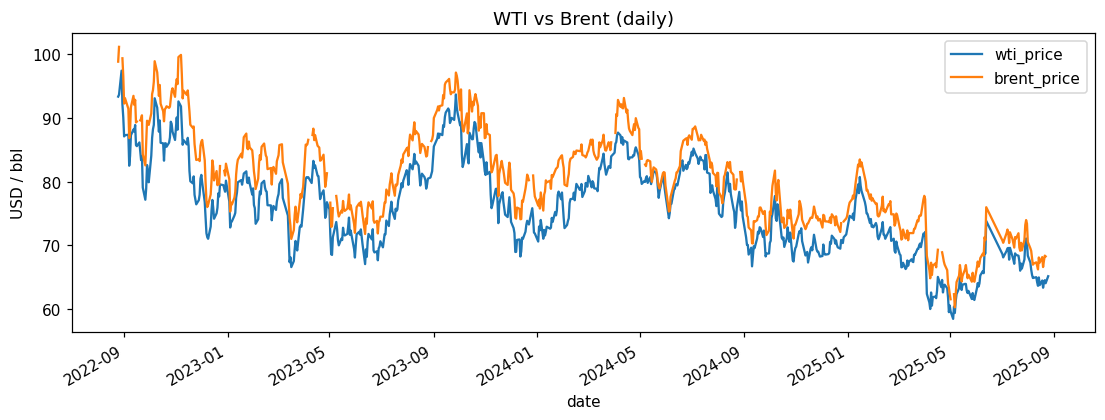

In [ ]:
price_df = (
    df[["date", "wti_price", "brent_price"]]
    .drop_duplicates(subset="date")          # one row per calendar day
    .set_index("date")
    .sort_index()
)
price_df.plot(figsize=(12, 4), title="WTI vs Brent (daily)")
plt.ylabel("USD / bbl")
plt.show()

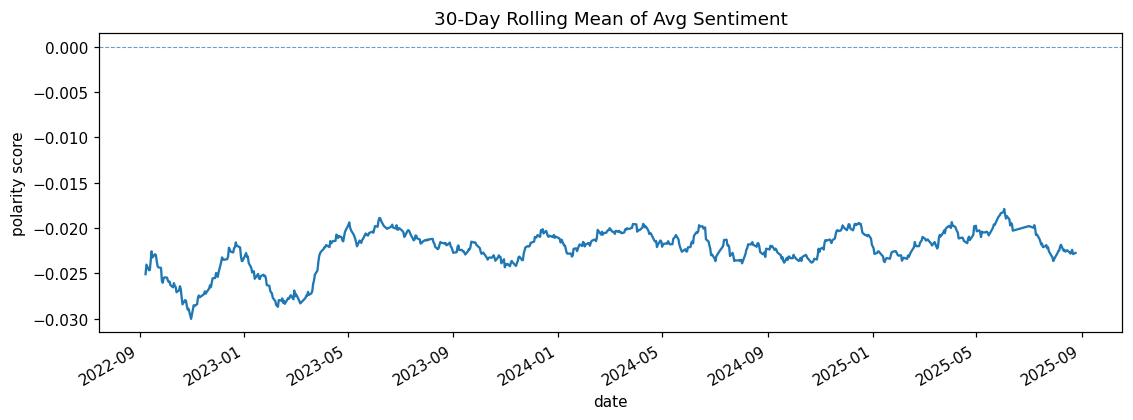

In [ ]:
sentiment_roll = (
    df.groupby("date")["avg_sentiment"]
      .mean()
      .rolling(30, min_periods=10)
      .mean()
)
sentiment_roll.plot(figsize=(12, 4), title="30-Day Rolling Mean of Avg Sentiment")
plt.axhline(0, lw=0.7, ls="--", alpha=0.7)
plt.ylabel("polarity score")
plt.show()

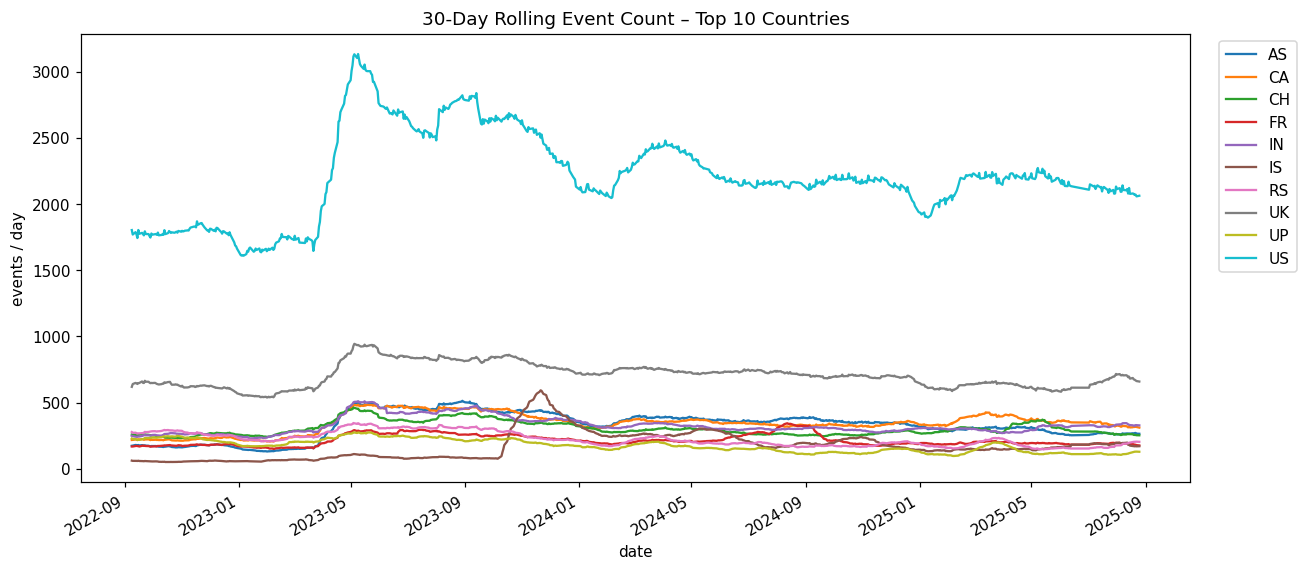

In [ ]:
top10 = (
    df.groupby("country")["event_count"].sum()
      .sort_values(ascending=False)
      .head(10).index
)

activity = (
    df[df["country"].isin(top10)]
      .groupby(["date", "country"])["event_count"]
      .sum()
      .unstack()
      .rolling(30, min_periods=10).mean()
)
activity.plot(figsize=(13, 6), title="30-Day Rolling Event Count – Top 10 Countries")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.ylabel("events / day")
plt.show()


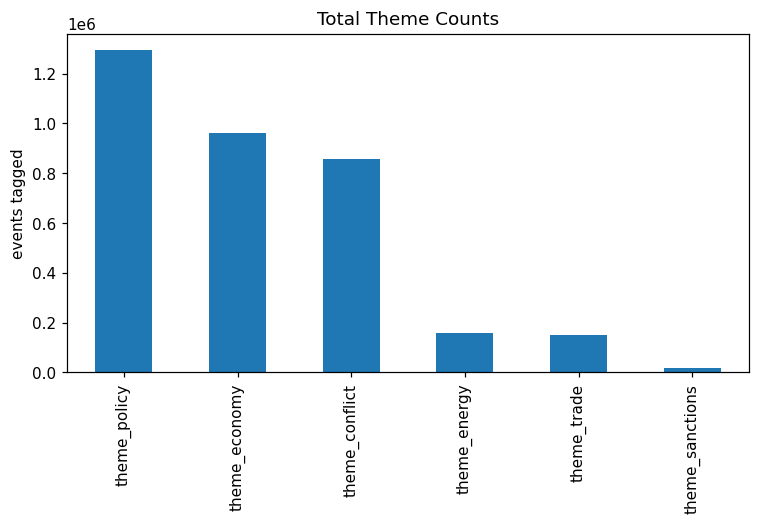

In [ ]:
theme_cols = [c for c in df.columns if c.startswith("theme_")]
(df[theme_cols].sum()
   .sort_values(ascending=False)
   .plot(kind="bar", figsize=(8, 4), title="Total Theme Counts"))
plt.ylabel("events tagged")
plt.show()


Pearson r: -0.14


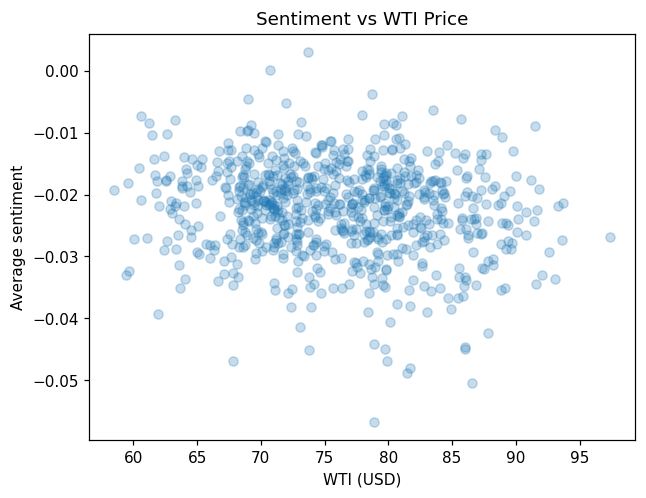

In [ ]:
merged = (
    df.groupby("date")
      .agg(avg_sent=("avg_sentiment", "mean"),
           wti=("wti_price", "first"))
      .dropna()
)
print("Pearson r:", merged["avg_sent"].corr(merged["wti"]).round(3))

plt.scatter(merged["wti"], merged["avg_sent"], alpha=0.25)
plt.title("Sentiment vs WTI Price")
plt.xlabel("WTI (USD)")
plt.ylabel("Average sentiment")
plt.show()


Diagnose sentiments vs WTI Price

In [ ]:
dup_mask = df.duplicated(subset=["date","country"], keep=False)
print("Potential duplicates:", dup_mask.sum())

print("\nNulls per column:")
print(df.isna().sum())

from scipy import stats
z = stats.zscore(df["avg_sentiment"])
df.loc[(z<-4)|(z>4), "avg_sentiment"] = None


Potential duplicates: 0

Nulls per column:
date                  0
country               0
event_count           0
avg_sentiment         0
unique_sources        0
wti_price             0
brent_price        2868
theme_energy          0
theme_conflict        0
theme_sanctions       0
theme_trade           0
theme_economy         0
theme_policy          0
dtype: int64


In [ ]:
df["w_sent"] = df["avg_sentiment"] * df["event_count"]

energy_mask = (
    (df["theme_energy"]>0) |
    (df["theme_policy"]>0) |
    (df["theme_sanctions"]>0)
)
energy_daily = (
    df[energy_mask]
      .groupby("date")[["w_sent","event_count"]]
      .sum()
      .assign(energy_sent=lambda d: d["w_sent"]/d["event_count"])
      .loc[:,["energy_sent"]]
)

global_daily = (
    df.groupby("date")[["w_sent","event_count"]]
      .sum()
      .assign(global_sent=lambda d: d["w_sent"]/d["event_count"])
      .loc[:,["global_sent"]]
)

producers = {"SA", "RU", "US", "IR", "IQ", "CA", "CN", "BR", "AE", "KZ"}
df["bucket"] = df["country"].where(df["country"].isin(producers),"OTHER")

bucket_daily = (
    df.groupby(["date","bucket"])[["w_sent","event_count"]]
      .sum()
      .assign(sent=lambda d: d["w_sent"]/d["event_count"])
      .reset_index()
      .pivot(index="date", columns="bucket", values="sent")
      .add_prefix("sent_")
)

sent_daily = (
    global_daily
      .join(energy_daily, how="outer")
      .join(bucket_daily, how="outer")
      .sort_index()
)


In [ ]:
price_df = (
    df[["date","wti_price"]]
      .drop_duplicates("date")
      .set_index("date")
      .sort_index()
)
price_df["wti_logret"] = np.log(price_df["wti_price"]).diff()

signals = price_df.join(sent_daily, how="inner")
signals = signals.dropna(subset=["wti_logret"])        # start after first diff


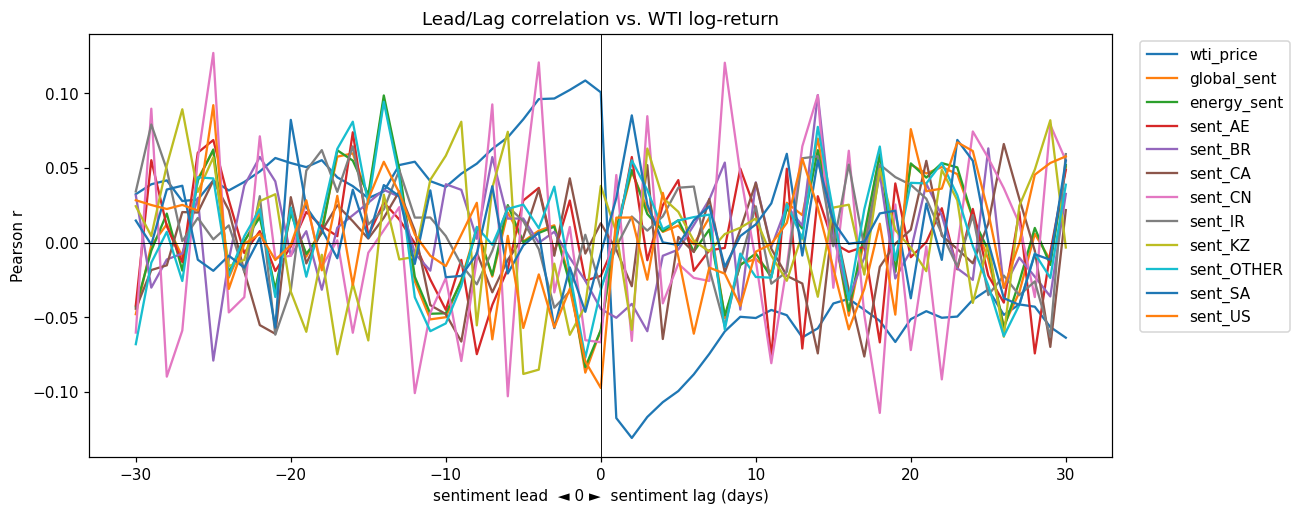

{'wti_price': 2,
 'global_sent': -14,
 'energy_sent': -14,
 'sent_AE': 11,
 'sent_BR': 14,
 'sent_CA': 17,
 'sent_CN': -25,
 'sent_IR': -29,
 'sent_KZ': -27,
 'sent_OTHER': -14,
 'sent_SA': 2,
 'sent_US': 0}

In [ ]:
# cross-correlations  -30 … +30 days
lags = range(-30, 31)
corrs = {
    col: [signals["wti_logret"].corr(signals[col].shift(l)) for l in lags]
    for col in signals.columns if col != "wti_logret"
}

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
for col, vals in corrs.items():
    plt.plot(lags, vals, label=col)
plt.axhline(0, color="k", lw=.6)
plt.axvline(0, color="k", lw=.6)
plt.title("Lead/Lag correlation vs. WTI log-return")
plt.xlabel("sentiment lead  ◄ 0 ►  sentiment lag (days)")
plt.ylabel("Pearson r")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.show()

# pick best lag per feature
best_lag = {col: lags[np.argmax(np.abs(v))] for col, v in corrs.items()}
best_lag


In [ ]:
final_signals = signals.copy()
for col, l in best_lag.items():
    final_signals[f"{col}_lag{l:+}"] = final_signals[col].shift(l)

feature_df = (
    final_signals
      .drop(columns=[c for c in signals.columns if c!="wti_logret"])
      .dropna()
)
feature_df.to_parquet("wti_features.parquet")
print("Final feature shape:", feature_df.shape)
feature_df.head()


Final feature shape: (281, 13)


,wti_logret,wti_price_lag+2,global_sent_lag-14,energy_sent_lag-14,sent_AE_lag+11,sent_BR_lag+14,sent_CA_lag+17,sent_CN_lag-25,sent_IR_lag-29,sent_KZ_lag-27,sent_OTHER_lag-14,sent_SA_lag+2,sent_US_lag+0
date,,,,,,,,,,,,,
2022-09-21,-0.015589,86.15,-0.014832,-0.014639,-0.003587,0.002764,-0.009933,-0.234828,-0.009252,-0.017001,-0.014581,-0.026373,-0.024659
2022-09-30,-0.023132,82.61,-0.023691,-0.023506,-0.005852,0.015022,-0.024818,-0.042204,-0.059209,0.023923,-0.021644,-0.016202,-0.031319
2022-10-12,-0.021625,91.60,-0.013794,-0.013961,-0.025517,-0.030786,-0.028947,-0.045816,-0.038913,-0.009034,-0.012542,-0.041008,-0.035943
2022-10-13,0.019841,89.75,-0.021591,-0.021840,-0.021277,-0.011061,-0.003600,0.000000,0.007751,0.014914,-0.019631,-0.044637,-0.022893
2022-10-17,-0.001162,89.59,-0.018247,-0.017891,-0.054899,-0.025525,-0.034824,0.000000,-0.001780,0.031914,-0.018075,-0.035447,-0.025084


Using feature: wti_price_lag+2 | r = -0.131


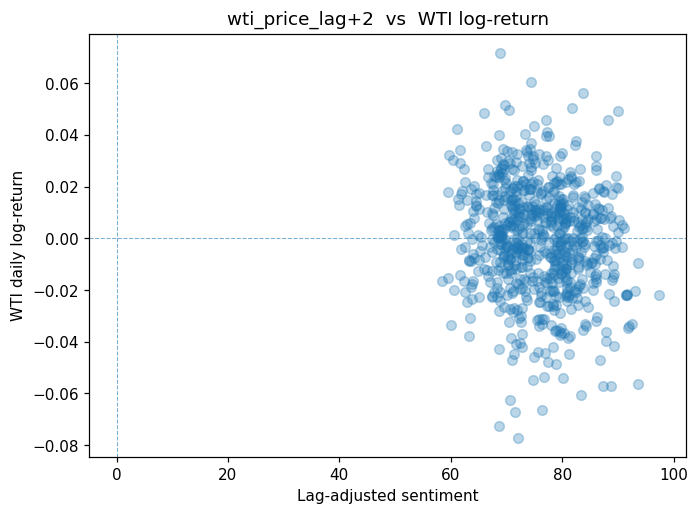

In [ ]:
corr_pairs = {
    f"{col}_lag{lag:+}": signals["wti_logret"].corr(signals[col].shift(lag))
    for col, lag in best_lag.items()
}
sent_feat = max(corr_pairs, key=lambda k: abs(corr_pairs[k]))
print("Using feature:", sent_feat, "| r =", round(corr_pairs[sent_feat], 3))

plt.figure(figsize=(7,5))
plt.scatter(
    final_signals[sent_feat],
    final_signals["wti_logret"],
    alpha=0.3, s=40
)
plt.title(f"{sent_feat}  vs  WTI log-return")
plt.xlabel("Lag-adjusted sentiment")
plt.ylabel("WTI daily log-return")
plt.axhline(0, lw=0.7, ls="--", alpha=0.6)
plt.axvline(0, lw=0.7, ls="--", alpha=0.6)
plt.show()


Re-computing ['global_sent', 'energy_sent']


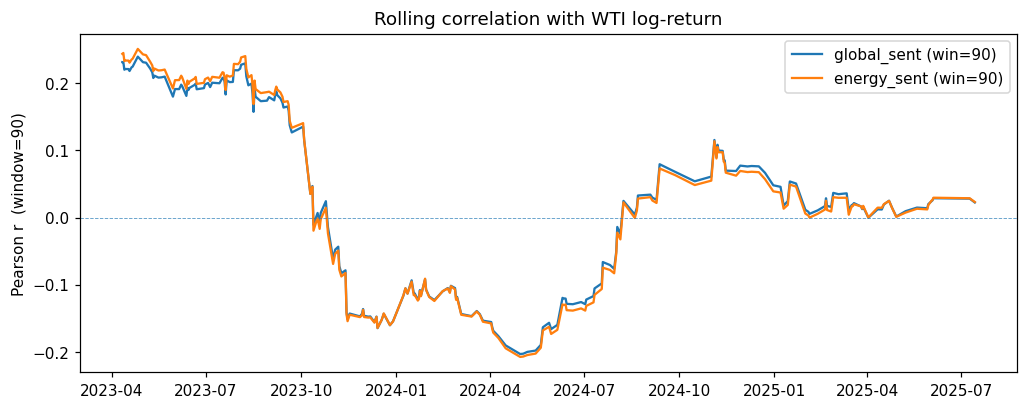

In [ ]:
plt.rcParams["figure.dpi"] = 110

def _derive_signals(base_df: pd.DataFrame) -> pd.DataFrame:
    """Return a DataFrame with global_sent and energy_sent."""
    tmp = base_df.copy()
    tmp["w_sent"] = tmp["avg_sentiment"] * tmp["event_count"]

    global_daily = (
        tmp.groupby("date")[["w_sent", "event_count"]]
           .sum()
           .assign(global_sent=lambda d: d["w_sent"]/d["event_count"])
           .loc[:, ["global_sent"]]
    )

    energy_mask = (
        (tmp["theme_energy"]>0) |
        (tmp["theme_policy"]>0) |
        (tmp["theme_sanctions"]>0)
    )
    energy_daily = (
        tmp[energy_mask]
           .groupby("date")[["w_sent", "event_count"]]
           .sum()
           .assign(energy_sent=lambda d: d["w_sent"]/d["event_count"])
           .loc[:, ["energy_sent"]]
    )

    return global_daily.join(energy_daily, how="outer")

missing = [c for c in ["global_sent", "energy_sent"] if c not in feature_df.columns]
if missing:
    print("Re-computing", missing)
    sent_daily = _derive_signals(df)          # <- uses the raw dataframe
    feature_df = feature_df.join(sent_daily, how="left")

roll = (
    feature_df[["global_sent", "energy_sent", "wti_logret"]]
      .dropna(subset=["wti_logret"])
)
win = 90

plt.figure(figsize=(11,4))
for col in ["global_sent", "energy_sent"]:
    if col in roll:
        r = roll[col].rolling(win, min_periods=int(win*0.6)).corr(roll["wti_logret"])
        plt.plot(r.index, r, label=f"{col} (win={win})")
plt.axhline(0, lw=0.6, ls="--", alpha=0.7)
plt.title("Rolling correlation with WTI log-return")
plt.ylabel(f"Pearson r  (window={win})")
plt.legend()
plt.show()


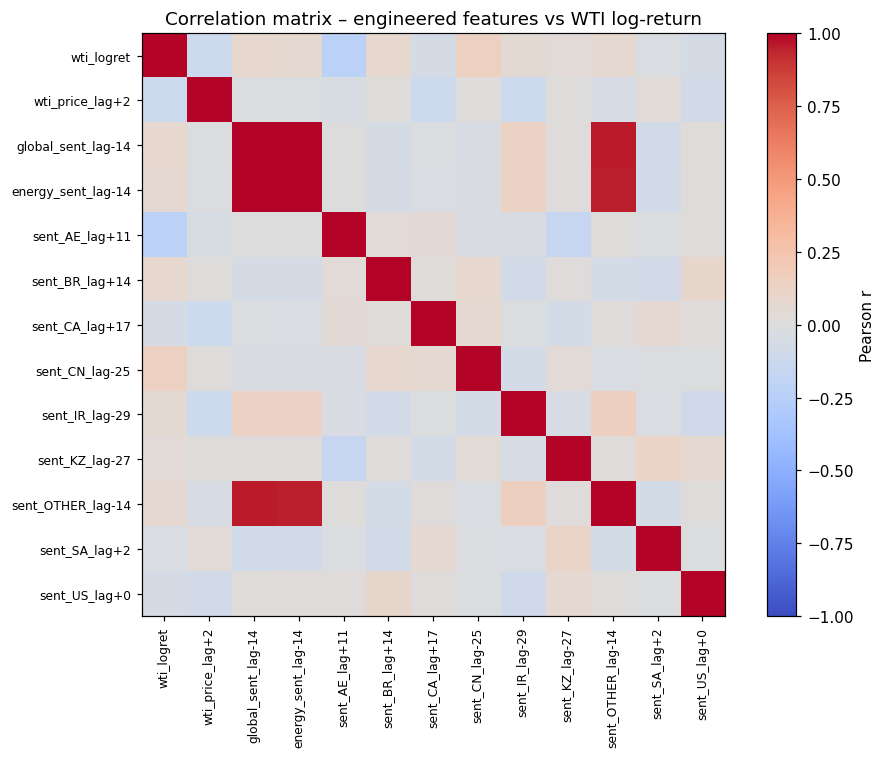

In [ ]:
corr = feature_df.select_dtypes("number").corr()

plt.figure(figsize=(9,7))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.xticks(range(len(corr)), corr.columns, rotation=90, fontsize=8)
plt.yticks(range(len(corr)), corr.columns, fontsize=8)
plt.colorbar(label="Pearson r")
plt.title("Correlation matrix – engineered features vs WTI log-return")
plt.tight_layout(); plt.show()


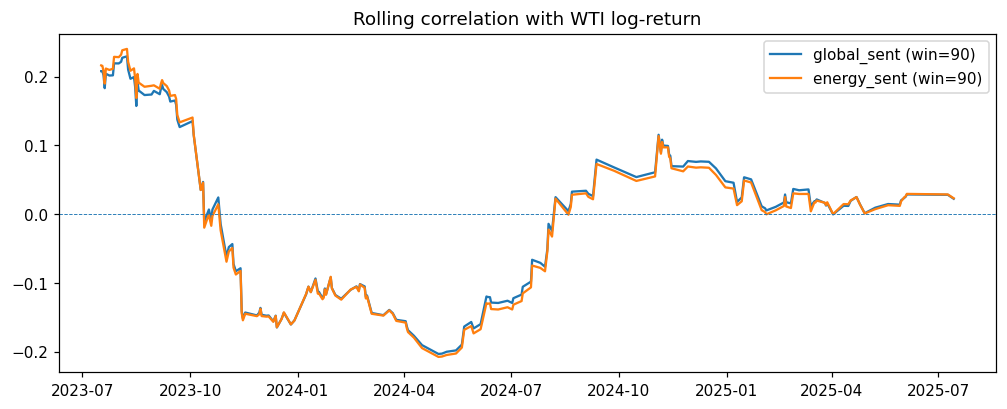

In [ ]:
roll = feature_df[["global_sent", "energy_sent", "wti_logret"]].dropna()
win  = 90
plt.figure(figsize=(11,4))
for col in ["global_sent", "energy_sent"]:
    r = roll[col].rolling(win).corr(roll["wti_logret"])
    plt.plot(r.index, r, label=f"{col} (win={win})")
plt.axhline(0, lw=.6, ls="--")
plt.title("Rolling correlation with WTI log-return")
plt.legend(); plt.show()


Rebuilt bucket cols: ['sent_AE_lag+11', 'sent_BR_lag+14', 'sent_CA_lag+17', 'sent_CN_lag-25', 'sent_IR_lag-29', 'sent_KZ_lag-27', 'sent_OTHER_lag-14', 'sent_SA_lag+2', 'sent_US_lag+0', 'sent_AE', 'sent_BR', 'sent_CA', 'sent_CN', 'sent_IR', 'sent_KZ', 'sent_MX', 'sent_NO', 'sent_OTHER', 'sent_QA', 'sent_SA', 'sent_US']


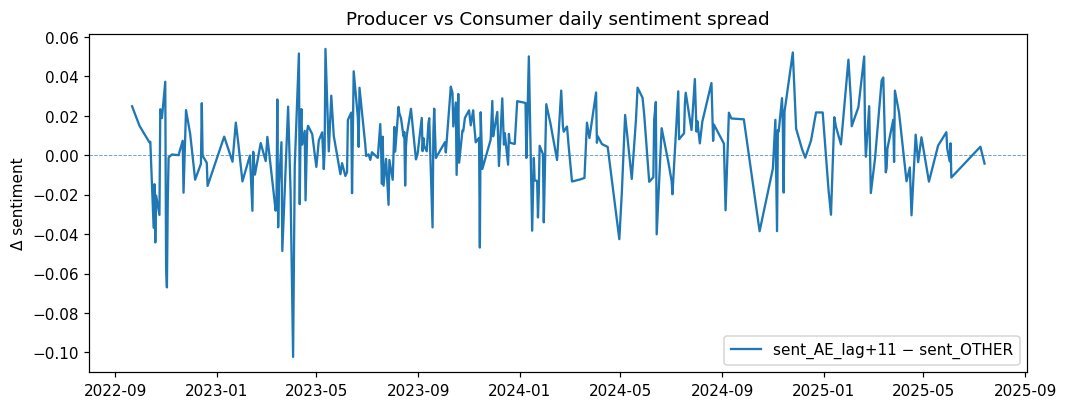

In [ ]:
plt.rcParams["figure.dpi"] = 110

if "w_sent" not in df.columns:
    df["w_sent"] = df["avg_sentiment"] * df["event_count"]

bucket_cols = [c for c in feature_df.columns if c.startswith("sent_")]

if "sent_OTHER" not in bucket_cols:
    known_producers = {
        "US","RU","SA","CN","CA","IQ","IR","AE","BR","KW","KZ","QA","MX","NO"}
    present = set(df["country"].unique())
    producers = sorted(known_producers & present)
    if not producers:
        producers = df["country"].value_counts().head(5).index.tolist()

    df["bucket"] = df["country"].where(df["country"].isin(producers), "OTHER")

    bucket_daily = (
        df.groupby(["date","bucket"])[["w_sent","event_count"]]
          .sum()
          .assign(sent=lambda d: d["w_sent"]/d["event_count"])
          .reset_index()
          .pivot(index="date", columns="bucket", values="sent")
          .add_prefix("sent_")
    )

    for col in [f"sent_{p}" for p in producers] + ["sent_OTHER"]:
        if col not in bucket_daily.columns:
            bucket_daily[col] = np.nan

    feature_df = feature_df.join(bucket_daily, how="left")
    bucket_cols = [c for c in feature_df.columns if c.startswith("sent_")]
    print("Rebuilt bucket cols:", bucket_cols)

prod_candidates = [c for c in bucket_cols if c != "sent_OTHER"]
if not prod_candidates:
    raise ValueError("No producer sentiment column found.")
prod_col = prod_candidates[0]

if "sent_OTHER" not in feature_df.columns:
    feature_df["sent_OTHER"] = np.nan

spread = feature_df[prod_col] - feature_df["sent_OTHER"]

plt.figure(figsize=(11,4))
plt.plot(spread.index, spread, label=f"{prod_col} − sent_OTHER")
plt.axhline(0, lw=0.6, ls="--", alpha=0.7)
plt.title("Producer vs Consumer daily sentiment spread")
plt.ylabel("Δ sentiment")
plt.legend()
plt.show()


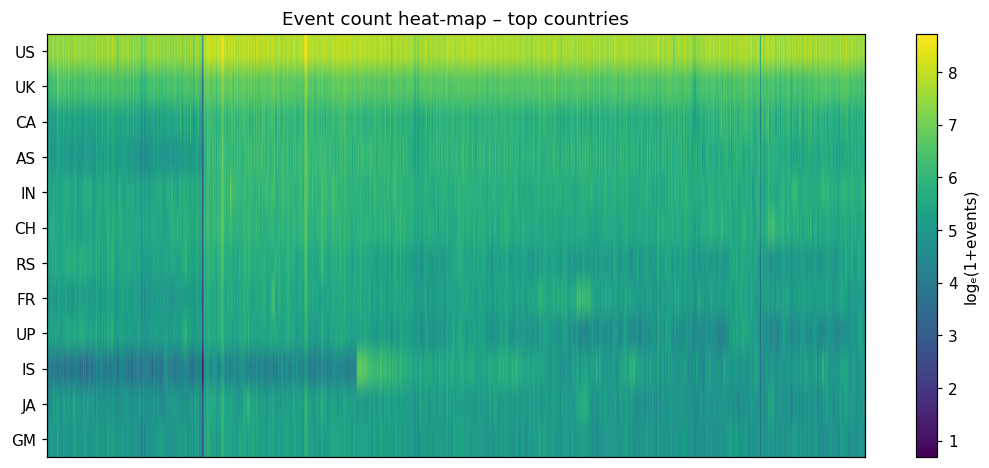

In [ ]:
pivot = (
    df.groupby(["date","country"])["event_count"]
      .sum()
      .reset_index()
      .pivot(index="date", columns="country", values="event_count")
      .fillna(0)
      .astype(int)
)
# keep top 12 by total volume
top_cols = pivot.sum().sort_values(ascending=False).head(12).index
sub = pivot[top_cols]

plt.figure(figsize=(12,5))
plt.imshow(np.log1p(sub.T), aspect="auto")
plt.yticks(range(len(top_cols)), top_cols)
plt.xticks([])  # dense, omit
plt.colorbar(label="logₑ(1+events)")
plt.title("Event count heat-map – top countries")
plt.show()


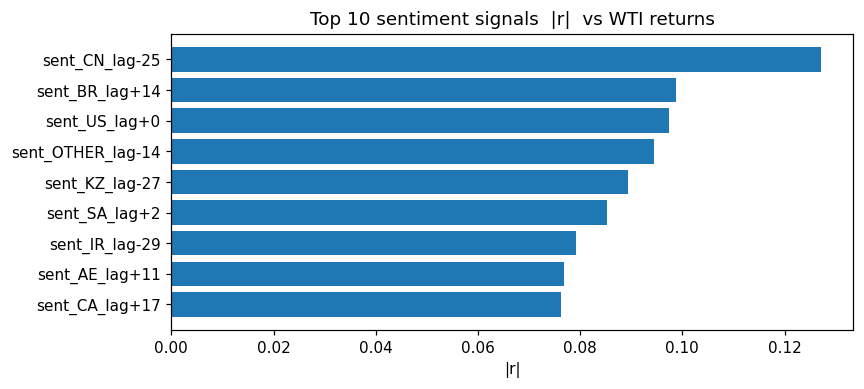

In [ ]:
lags, vals = zip(
    *sorted(((k, abs(v)) for k,v in corr_pairs.items()
             if k.startswith("sent_") or k.endswith("_sent")),
            key=lambda x: x[1], reverse=True)[:10]
)
plt.figure(figsize=(8,3.5))
plt.barh(lags, vals)
plt.gca().invert_yaxis()
plt.title("Top 10 sentiment signals  |r|  vs WTI returns")
plt.xlabel("|r|"); plt.show()


chosen k = 3 | BIC = 25016.503439816945


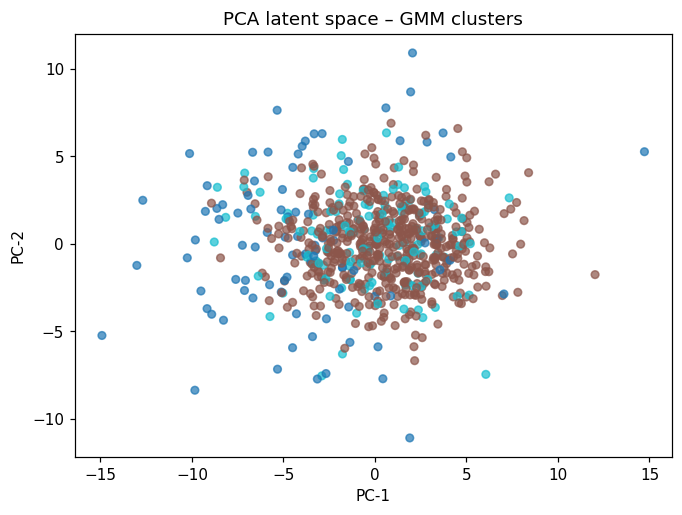

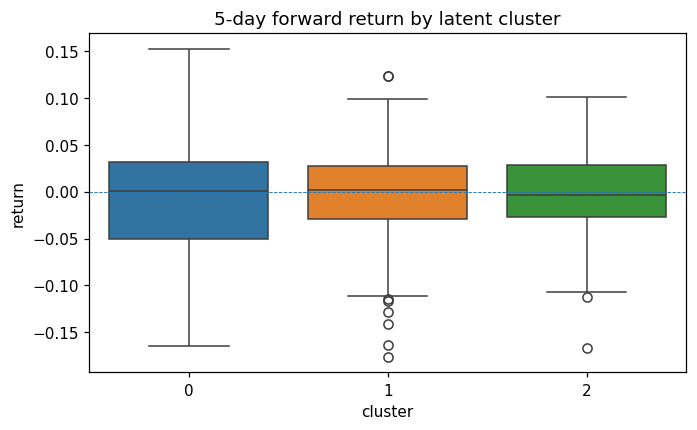

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

idx   = pivot.index
X_raw = pivot.fillna(0).values

X_scaled = StandardScaler().fit_transform(X_raw)
pca      = PCA(n_components=0.9, svd_solver="full", random_state=0)
Z        = pca.fit_transform(X_scaled)   # latent matrix

bics, models = [], []
for k in range(2, 9):
    gmm = GaussianMixture(k, covariance_type="full", random_state=0).fit(Z)
    bics.append(gmm.bic(Z)); models.append(gmm)
best   = models[np.argmin(bics)]
labels = best.predict(Z)
print("chosen k =", best.n_components, "| BIC =", min(bics))

plt.figure(figsize=(7,5))
plt.scatter(Z[:,0], Z[:,1], c=labels, cmap="tab10", s=25, alpha=.7)
plt.title("PCA latent space – GMM clusters")
plt.xlabel("PC-1"); plt.ylabel("PC-2"); plt.show()

price = (
    df[["date","wti_price"]].drop_duplicates("date")
      .set_index("date").sort_index()
)
price["fwd5"] = np.log(price["wti_price"]).shift(-5) - np.log(price["wti_price"])
ret = price["fwd5"].reindex(idx)

box = pd.DataFrame({"return": ret, "cluster": labels}).dropna()
plt.figure(figsize=(7,4))
sns.boxplot(x="cluster", y="return", data=box, palette="tab10")
plt.axhline(0, lw=.6, ls="--")
plt.title("5-day forward return by latent cluster")
plt.show()


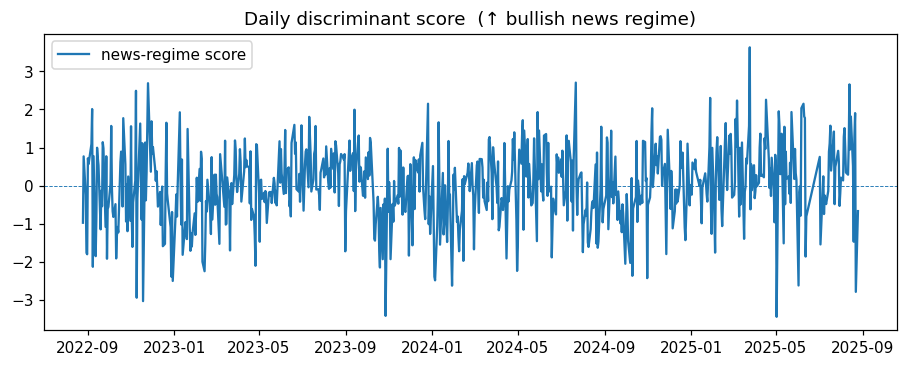

Corr(score, 5-day return) = nan


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

y = (ret > 0).astype(int).values
mask = ~np.isnan(y)
lda  = LDA().fit(Z[mask], y[mask])
score = pd.Series(lda.transform(Z)[:,0], index=idx)

plt.figure(figsize=(10,3.5))
plt.plot(score.index, score, label="news-regime score")
plt.axhline(0, lw=.6, ls="--")
plt.title("Daily discriminant score  (↑ bullish news regime)")
plt.legend(); plt.show()

print("Corr(score, 5-day return) =", np.corrcoef(score, ret)[0,1].round(3))
